In [1]:
import os
import tempfile
from typing import Dict, Optional

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule
from torchgeo.transforms import AugmentationSequential, indices
from torchgeo.trainers import ClassificationTask
from torchgeo.models import ResNet18_Weights

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger

seed_everything(543)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Global seed set to 543


cpu


Setup the datamodule - validate train_dataset

In [18]:
if device == "cuda":
    batch_size = 64
    num_workers = 8
elif device ==  "cpu":
    batch_size = 16 # TODO check why this is not picked up
    num_workers = 0
else:
    print("unknown device!")

rgb_bands = ("B04", "B03", "B02") # or experiment with all

datamodule = EuroSATDataModule(
    batch_size=batch_size, 
    root="data", 
    num_workers=num_workers, 
    # bands=rgb_bands, # RE RGB only: https://github.com/microsoft/torchgeo/issues/1634
    download=True,
    transforms=None,
)

Do some validation on the train set

In [11]:
datamodule.prepare_data()
datamodule.setup('fit')
len(datamodule.train_dataset)

16200

In [12]:
datamodule.train_dataset.bands

('B04', 'B03', 'B02')

In [13]:
datamodule.train_dataset[0]['image'].shape

torch.Size([3, 64, 64])

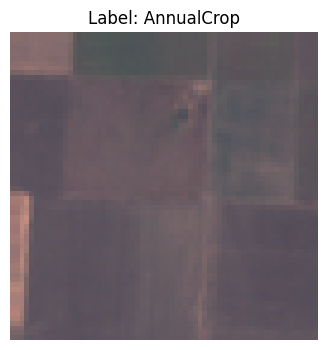

In [14]:
sample = datamodule.train_dataset[0]
fig = datamodule.train_dataset.plot(sample)

Experiment with the model and pretrained weights -> https://torchgeo.readthedocs.io/en/stable/tutorials/pretrained_weights.html

In [15]:
task = ClassificationTask(
    model="resnet18",
    # weights=True, # standard Imagenet
    # weights=ResNet18_Weights.SENTINEL2_ALL_MOCO, # or try sentinel 2 all bands
    weights=ResNet18_Weights.SENTINEL2_RGB_MOCO, # or try sentinel 2 rgb bands
    num_classes=10,
    in_channels=len(datamodule.train_dataset.bands), # make sure to validate
    loss="ce", 
    patience=10
)

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

logger = TensorBoardLogger("tensorboard_logs", name="eurosat")

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    accelerator=device,
    logger=logger,
    # default_root_dir=experiment_dir,
    min_epochs=15,
    max_epochs=50,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


ValueError: mean length and number of channels do not match. Got torch.Size([13]) and torch.Size([16, 3, 64, 64]).

In [10]:
trainer.test(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.9494212865829468     │
│       test_F1Score        │    0.9525926113128662     │
│     test_JaccardIndex     │    0.9072655439376831     │
│   test_OverallAccuracy    │    0.9525926113128662     │
│         test_loss         │    0.1797962188720703     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1797962188720703,
  'test_AverageAccuracy': 0.9494212865829468,
  'test_F1Score': 0.9525926113128662,
  'test_JaccardIndex': 0.9072655439376831,
  'test_OverallAccuracy': 0.9525926113128662}]

The model checkpoint is saved below:

In [11]:
os.listdir("tensorboard_logs/eurosat/version_0/checkpoints")

['epoch=7-step=2032.ckpt']